# Installs

In [ ]:
!pip install rouge-score
!pip uninstall -y wandb

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=cf71549e540e67432f534cdab9bbf1ba2b217450f65b8624c0ca9c6b3e702980
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1
  Preparing metadata (setup.py) ... done
     โโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
     โโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโโ 556.4/556.4 kB 11.9 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   โโโโโโโโโโโโโโโ

# Libraries

In [ ]:
import re
import ast
import torch
import tokenizers
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, AutoTokenizer, T5Tokenizer, MT5ForConditionalGeneration, MT5Tokenizer, EarlyStoppingCallback

# Reading Data

In [ ]:

df_tydiqa = pd.read_csv('/kaggle/input/tydiqa-data/tydiqa-arabic.csv')
print("tydiqa data loaded")

# Data Overview

In [4]:
df_tydiqa.head()

id  \
0   arabic-2387335860751143628-1   
1  arabic--3358420169913421088-0   
2   arabic-6869798435672288559-0   
3   arabic-1608369850259830544-0   
4  arabic--7165672200361826550-0   

                                            question  \
0  ูู ุนุฏุฏ ูุฑุงุช ููุฒ ุงูุฃูุฑูุบูุงู ุจุจุทููุฉ ูุงุณ ุงูุนุงูู ู...   
1                    ูู ูู ููุชุดู ุงููุฑู ุฃู ุงูููุงุฑุชุฒ ุ   
2                           ููู ูุชุตู ุงูุฌููู ุจุงูุฑุญู ุ   
3           ูุง ูู ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏุ   
4                   ุฃูู ููุน ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ   

                                             context  \
0  ุฃูููุช ุงูุจุทููุฉ 21 ูุฑุฉุ ุดุงุฑู ูู ุงูููุงุฆูุงุช 78 ุฏูู...   
1  ุงููุฑู ุฃู ุงูููุงุฑุชุฒ  ูู ูุนุฏู ูุนูุฏ ุงูุชุดุงูู ุฅูู ุงู...   
2   ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏ (ุจุงูุฅูุฌููุฒู...   
3   ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏ (ุจุงูุฅูุฌููุฒู...   
4  ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ ูู ูุณุฌุฏ ุฃุซุฑู ุชุงุฑูุฎู ู...   

                                             answers  c_id  
0         [{'text': 'ุจุทููุชูู', 'answer_start': 394}]     0  
1  [{'text': '(ุจููุฑ ููุฑู) ูุฃุฎูู (ุฌุงู)', 'answer_s...     1  
2  [{'text': 'ุนู ุทุฑูู ุงูุญุจู ุงูุณุฑู', 'answer_start...     2  
3  [{'text': 'ุนุถู ุฏุงุฆุฑู ูุณุทุญ ุงูุดูู ูุชุตู ุจุงูุฌููู ุน...     2  
4  [{'text': 'ูุฏููุฉ ุฌุจูู ุงููุจูุงููุฉ', 'answer_star...     3

In [5]:
df_tydiqa.shape

(921, 5)

In [6]:
df_tydiqa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        921 non-null    object
 1   question  921 non-null    object
 2   context   921 non-null    object
 3   answers   921 non-null    object
 4   c_id      921 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 36.1+ KB


# Removing id column

In [7]:
df_tydiqa.drop('id', axis=1, inplace=True)

In [8]:
df_tydiqa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  921 non-null    object
 1   context   921 non-null    object
 2   answers   921 non-null    object
 3   c_id      921 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 28.9+ KB


In [9]:
df_tydiqa.head(10)

question  \
0  ูู ุนุฏุฏ ูุฑุงุช ููุฒ ุงูุฃูุฑูุบูุงู ุจุจุทููุฉ ูุงุณ ุงูุนุงูู ู...   
1                    ูู ูู ููุชุดู ุงููุฑู ุฃู ุงูููุงุฑุชุฒ ุ   
2                           ููู ูุชุตู ุงูุฌููู ุจุงูุฑุญู ุ   
3           ูุง ูู ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏุ   
4                   ุฃูู ููุน ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ   
5                                   ูุง ุนุงุตูุฉ ุฌูุฑุฌูุงุ   
6                                ูุง ูู ุนุงุตูุฉ ุฌูุฑุฌูุงุ   
7                        ูุง ูู ุนุฏุฏ ุขูุงุช ุณูุฑุฉ ุงูููู ุ   
8       ูุง ุณุจุจ ููุงุฉ ูุงุนุจ ููุงู ุงูุฃุฌุณุงู ูุงุตุฑ ุงูุณูุจุงุทูุ   
9                        ูู ูู ูุฎุชุฑุน ุงููุญุฑู ุงูุจุฎุงุฑูุ   

                                             context  \
0  ุฃูููุช ุงูุจุทููุฉ 21 ูุฑุฉุ ุดุงุฑู ูู ุงูููุงุฆูุงุช 78 ุฏูู...   
1  ุงููุฑู ุฃู ุงูููุงุฑุชุฒ  ูู ูุนุฏู ูุนูุฏ ุงูุชุดุงูู ุฅูู ุงู...   
2   ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏ (ุจุงูุฅูุฌููุฒู...   
3   ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏ (ุจุงูุฅูุฌููุฒู...   
4  ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ ูู ูุณุฌุฏ ุฃุซุฑู ุชุงุฑูุฎู ู...   
5  ุฑุบู ุณูุทุฑุฉ ุงููุณูููู ุนูู ุงูุนุงุตูุฉ ุชุจููุณู ูู 645 ู...   
6  ุฑุบู ุณูุทุฑุฉ ุงููุณูููู ุนูู ุงูุนุงุตูุฉ ุชุจููุณู ูู 645 ู...   
7  ุณูุฑุฉ ุงูููู ูู ุณูุฑุฉู ูููุฉู ุฑูููุง 18ุ ุชุณุจู ุณูุฑุฉ ...   
8  ุชููู ูุงุตุฑ ุงูุณูุจุงุทู ููู 20 ูุงุฑุณ 2013 ูู ุงููุงูุฑุฉ...   
9  ูุฎุชุฑุน ุงููุญุฑู ุงูุจุฎุงุฑู ูู ุฌููุณ ูุงุท (1736 โ 1819ู...   

                                             answers  c_id  
0         [{'text': 'ุจุทููุชูู', 'answer_start': 394}]     0  
1  [{'text': '(ุจููุฑ ููุฑู) ูุฃุฎูู (ุฌุงู)', 'answer_s...     1  
2  [{'text': 'ุนู ุทุฑูู ุงูุญุจู ุงูุณุฑู', 'answer_start...     2  
3  [{'text': 'ุนุถู ุฏุงุฆุฑู ูุณุทุญ ุงูุดูู ูุชุตู ุจุงูุฌููู ุน...     2  
4  [{'text': 'ูุฏููุฉ ุฌุจูู ุงููุจูุงููุฉ', 'answer_star...     3  
5           [{'text': 'ุชุจููุณู', 'answer_start': 31}]     4  
6           [{'text': 'ุชุจููุณู', 'answer_start': 31}]     4  
7  [{'text': '110', 'answer_start': 110}, {'text'...     5  
8       [{'text': 'ุฃุซูุงุก ูููู', 'answer_start': 84}]     6  
9         [{'text': 'ุฌููุณ ูุงุท', 'answer_start': 24}]     7

# Text Preprocessing

## text cleaning functions

### Normalization

In [10]:
def remove_diacritics(text):
    # remove diacritics from the text as it may confuse the model
    return re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)


### Text cleaning

In [11]:
def remove_non_arabic(text):
    # Remove non-Arabic characters, keeping essential punctuation
    text = re.sub(r'[^\u0600-\u06FF\sุ]', '', text)
    return text

In [27]:
def remove_punk(text):
    # Remove punctuation
    arabic_punctuation = r'[ุุโฆ!"#$%&\'()*+,-./:;<=>@^_`{|}~]'
    text = re.sub(arabic_punctuation, '', text)
    return text

In [13]:
def remove_extra_spaces(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [14]:
def remove_alef_variations(text):
    text = re.sub(r'[ุฅุฃูฑุข]', 'ุง', text)
    return text

### Handling numbers

In [15]:
def handle_numbers(text, replace_with=None):
    if replace_with:
        text = re.sub(r'\d+', replace_with, text)
    else:
        text = re.sub(r'\d+', '', text)
    return text

## Stop word removal

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
stop_words = set(stopwords.words('arabic'))
print(stop_words)

{'ุฅู', 'ุชุณุนูู', 'ุชุณุนูุงุฆุฉ', 'ุฃุถุญู', 'ูู', 'ุญุณุจ', 'ููุณ', 'ูุงูุฐูู', 'ุฎูุณูู', 'ุขุถ', 'ุฃูุชู', 'ูุฆู', 'ุบุฏุงุฉ', 'ุจุณ', 'ููููู', 'ููู', 'ุฃูุง', 'ุฅูููู', 'ูุง', 'ุฅูุงูุง', 'ุซูุงุซูู', 'ูููู', 'ุขู', 'ูู', 'ูุฐู', 'ูููุง', 'ูู', 'ุฐูุช', 'ุฃุตูุง', 'ุนู', 'ุขุจ', 'ููุงูููุง', 'ุบูู', 'ุฃูุชู', 'ุฃุฑู', 'ูุฑุด', 'ุฎูุง', 'ุณุจุนูุฆุฉ', 'ุญุงุฑ', 'ููู', 'ุนูู', 'ุฃู', 'ุฎูุณ', 'ูุนููู', 'ุฃููุงูู', 'ุฏูุงููู', 'ุฏุฑู', 'ูู', 'ุนููู', 'ููู', 'ูุณู', 'ุขูู', 'ูููุง', 'ูุฃูู', 'ููุง', 'ููููู', 'ุฎูุณูุงุฆุฉ', 'ุจุฎู', 'ุฃูุฏ', 'ูุงุญุฏ', 'ููู', 'ุชุณุนูุฆุฉ', 'ุชููุฒ', 'ุฑ', 'ุฃุนูู', 'ุญูุซูุง', 'ุณุจุชูุจุฑ', 'ุจูู', 'ุขุฐุงุฑ', 'ุฌ', 'ุงููุฐูู', 'ุฃุฑุจุนูุฆุฉ', 'ุฃู', 'ูุฐูู', 'ุฑุฒู', 'ูููุง', 'ููุงููู', 'ููููุง', 'ูุฐุง', 'ููุฐุง', 'ุณุจุญุงู', 'ุงุณุชุญุงู', 'ุญูู', 'ุชุดุฑูู', 'ูุณุงุก', 'ุนุดุฑุฉ',

In [18]:
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

## Sentence splitting

In [19]:
def split_sentences(text):
    sentences = re.split(r'[ุ.!ุ]', text)
    # Remove empty sentences and strip spaces
    return [sentence.strip() for sentence in sentences if sentence.strip()]

## Remove additional spaces between letters

In [20]:
def fix_arabic_spacing(text):
    # Reconnect ุง to the previous word if it is fully isolated
    text = re.sub(r'(\S)\s+ุง\s+', r'\1ุง ', text)

    # Reconnect ุฃ and ู to the next word if they are fully isolated
    text = re.sub(r'\s+ุฃ\s+(\S)', r' ุฃ\1', text)
    text = re.sub(r'\s+ู\s+(\S)', r' ู\1', text)

    # Normalize spaces (remove extra spaces)
    text = remove_extra_spaces(text)

    return text

![image.png](attachment:image.png)

# Tokenization

In [23]:
!pip install SentencePiece 
import sentencepiece
print("SentencePiece version:", sentencepiece.__version__)

SentencePiece version: 0.2.0


### Selected tokenizer

In [24]:
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Apply Functions on the text

In [25]:
df_tydiqa.head(10)


question  \
0  ูู ุนุฏุฏ ูุฑุงุช ููุฒ ุงูุฃูุฑูุบูุงู ุจุจุทููุฉ ูุงุณ ุงูุนุงูู ู...   
1                    ูู ูู ููุชุดู ุงููุฑู ุฃู ุงูููุงุฑุชุฒ ุ   
2                           ููู ูุชุตู ุงูุฌููู ุจุงูุฑุญู ุ   
3           ูุง ูู ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏุ   
4                   ุฃูู ููุน ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ   
5                                   ูุง ุนุงุตูุฉ ุฌูุฑุฌูุงุ   
6                                ูุง ูู ุนุงุตูุฉ ุฌูุฑุฌูุงุ   
7                        ูุง ูู ุนุฏุฏ ุขูุงุช ุณูุฑุฉ ุงูููู ุ   
8       ูุง ุณุจุจ ููุงุฉ ูุงุนุจ ููุงู ุงูุฃุฌุณุงู ูุงุตุฑ ุงูุณูุจุงุทูุ   
9                        ูู ูู ูุฎุชุฑุน ุงููุญุฑู ุงูุจุฎุงุฑูุ   

                                             context  \
0  ุฃูููุช ุงูุจุทููุฉ 21 ูุฑุฉุ ุดุงุฑู ูู ุงูููุงุฆูุงุช 78 ุฏูู...   
1  ุงููุฑู ุฃู ุงูููุงุฑุชุฒ  ูู ูุนุฏู ูุนูุฏ ุงูุชุดุงูู ุฅูู ุงู...   
2   ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏ (ุจุงูุฅูุฌููุฒู...   
3   ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏ (ุจุงูุฅูุฌููุฒู...   
4  ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ ูู ูุณุฌุฏ ุฃุซุฑู ุชุงุฑูุฎู ู...   
5  ุฑุบู ุณูุทุฑุฉ ุงููุณูููู ุนูู ุงูุนุงุตูุฉ ุชุจููุณู ูู 645 ู...   
6  ุฑุบู ุณูุทุฑุฉ ุงููุณูููู ุนูู ุงูุนุงุตูุฉ ุชุจููุณู ูู 645 ู...   
7  ุณูุฑุฉ ุงูููู ูู ุณูุฑุฉู ูููุฉู ุฑูููุง 18ุ ุชุณุจู ุณูุฑุฉ ...   
8  ุชููู ูุงุตุฑ ุงูุณูุจุงุทู ููู 20 ูุงุฑุณ 2013 ูู ุงููุงูุฑุฉ...   
9  ูุฎุชุฑุน ุงููุญุฑู ุงูุจุฎุงุฑู ูู ุฌููุณ ูุงุท (1736 โ 1819ู...   

                                             answers  c_id  
0         [{'text': 'ุจุทููุชูู', 'answer_start': 394}]     0  
1  [{'text': '(ุจููุฑ ููุฑู) ูุฃุฎูู (ุฌุงู)', 'answer_s...     1  
2  [{'text': 'ุนู ุทุฑูู ุงูุญุจู ุงูุณุฑู', 'answer_start...     2  
3  [{'text': 'ุนุถู ุฏุงุฆุฑู ูุณุทุญ ุงูุดูู ูุชุตู ุจุงูุฌููู ุน...     2  
4  [{'text': 'ูุฏููุฉ ุฌุจูู ุงููุจูุงููุฉ', 'answer_star...     3  
5           [{'text': 'ุชุจููุณู', 'answer_start': 31}]     4  
6           [{'text': 'ุชุจููุณู', 'answer_start': 31}]     4  
7  [{'text': '110', 'answer_start': 110}, {'text'...     5  
8       [{'text': 'ุฃุซูุงุก ูููู', 'answer_start': 84}]     6  
9         [{'text': 'ุฌููุณ ูุงุท', 'answer_start': 24}]     7

### Questions column

In [35]:
df_tydiqa['processed_question'] = df_tydiqa['question'].apply(remove_diacritics).apply(remove_punk).apply(remove_extra_spaces)

* i tried to apply text clean function but i think it made some question not understandable

In [36]:
df_tydiqa['processed_question'].head(10)

0    ูู ุนุฏุฏ ูุฑุงุช ููุฒ ุงูุฃูุฑูุบูุงู ุจุจุทููุฉ ูุงุณ ุงูุนุงูู ู...
1                      ูู ูู ููุชุดู ุงููุฑู ุฃู ุงูููุงุฑุชุฒ ุ
2                             ููู ูุชุตู ุงูุฌููู ุจุงูุฑุญู ุ
3                    ูุง ูู ุงููุดููุฉ ุฃู ุงูุฎูุงุต ุฃู ุงูุณุฎุฏุ
4                     ุฃูู ููุน ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ
5                                     ูุง ุนุงุตูุฉ ุฌูุฑุฌูุงุ
6                                  ูุง ูู ุนุงุตูุฉ ุฌูุฑุฌูุงุ
7                          ูุง ูู ุนุฏุฏ ุขูุงุช ุณูุฑุฉ ุงูููู ุ
8         ูุง ุณุจุจ ููุงุฉ ูุงุนุจ ููุงู ุงูุฃุฌุณุงู ูุงุตุฑ ุงูุณูุจุงุทูุ
9                          ูู ูู ูุฎุชุฑุน ุงููุญุฑู ุงูุจุฎุงุฑูุ
Name: processed_question, dtype: object

### Context column

In [42]:
# remove punctuation from words
df_tydiqa['processed_context'] = df_tydiqa['context'].apply(remove_punk).apply(remove_diacritics).apply(remove_extra_spaces)

In [43]:
df_tydiqa['processed_context'][df_tydiqa['c_id'] == 543].tolist()[0]

'ุงููููููุฉ ุงููุงุฑุณูุฉ ูู ููุญุฉ ุฃู ุตูุฑุฉ ุตุบูุฑุฉ ุงูุญุฌู ุฅูุง ุชุณุชุฎุฏู ูุชูุถูุญ ูู ูุชุงุจ ุฃู ุชููู ุนููุง ูููุง ูุณุชููุง ุจุฐุงุชู ุงููููููุงุช ุงููุงุฑุณูุฉ ูุงูุช ุฐุงุช ุชุฃุซูุฑ ูุณูุทุฑ ุนูู ุฌููุน ุงููุณุฎ ุงูุฃุฎุฑู ูู ุงููููููุงุช ุงูุฅุณูุงููุฉ ุฎุตูุตุง ุงููููููุงุช ุงูุนุซูุงููุฉ ูู ุชุฑููุง ูุงููููููุงุช ุงููุบูููุฉ ูู ุงูููุฏ ุฃุตุจุญุช ุงููููููุงุช ุงููุงุฑุณูุฉ ุฐุงุช ุทุงุจุน ูุซูู ุจุงูุซูุงูุฉ ุงูุฅุณูุงููุฉ ุจุนุฏูุง ุฑูุฒุช ุนูู ุชุตููุฑ ูุนุงูู ููุธุงูุฑ ุฅุณูุงููุฉ ุฃู ุชุตููุฑ ุฎููุงุก ููุงุฏุฉ ุฅุณูุงูููู'

### Answers column

In [44]:
def extract_text(data):
    if isinstance(data, str):  # If data is a string, convert it to a list
        try:
            data = ast.literal_eval(data)  # Convert string to actual list
        except (SyntaxError, ValueError):
            return None  # If conversion fails, return None

    if isinstance(data, list) and data:  # Check if it's a valid non-empty list
        first_item = data[0]  # Access the first dictionary
        if isinstance(first_item, dict):  # Ensure it's a dictionary
            return first_item.get('text', None)  # Get the 'text' value or None if not found
    return None

In [45]:
df_tydiqa['processed_answers'] = df_tydiqa['answers'].apply(extract_text)

In [46]:
df_tydiqa['processed_answers'] = df_tydiqa['processed_answers'].apply(remove_diacritics).apply(remove_extra_spaces).apply(remove_punk)

In [47]:
df_tydiqa.head()

question  \
0  ูู ุนุฏุฏ ูุฑุงุช ููุฒ ุงูุฃูุฑูุบูุงู ุจุจุทููุฉ ูุงุณ ุงูุนุงูู ู...   
1                    ูู ูู ููุชุดู ุงููุฑู ุฃู ุงูููุงุฑุชุฒ ุ   
2                           ููู ูุชุตู ุงูุฌููู ุจุงูุฑุญู ุ   
3           ูุง ูู ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏุ   
4                   ุฃูู ููุน ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ   

                                             context  \
0  ุฃูููุช ุงูุจุทููุฉ 21 ูุฑุฉุ ุดุงุฑู ูู ุงูููุงุฆูุงุช 78 ุฏูู...   
1  ุงููุฑู ุฃู ุงูููุงุฑุชุฒ  ูู ูุนุฏู ูุนูุฏ ุงูุชุดุงูู ุฅูู ุงู...   
2   ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏ (ุจุงูุฅูุฌููุฒู...   
3   ุงูููุดููููุฉ ุฃู ุงูุฎููุงูุต ุฃู ุงูุณูุฎูุฏ (ุจุงูุฅูุฌููุฒู...   
4  ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ ูู ูุณุฌุฏ ุฃุซุฑู ุชุงุฑูุฎู ู...   

                                             answers  c_id  \
0         [{'text': 'ุจุทููุชูู', 'answer_start': 394}]     0   
1  [{'text': '(ุจููุฑ ููุฑู) ูุฃุฎูู (ุฌุงู)', 'answer_s...     1   
2  [{'text': 'ุนู ุทุฑูู ุงูุญุจู ุงูุณุฑู', 'answer_start...     2   
3  [{'text': 'ุนุถู ุฏุงุฆุฑู ูุณุทุญ ุงูุดูู ูุชุตู ุจุงูุฌููู ุน...     2   
4  [{'text': 'ูุฏููุฉ ุฌุจูู ุงููุจูุงููุฉ', 'answer_star...     3   

                                  processed_question  \
0  ูู ุนุฏุฏ ูุฑุงุช ููุฒ ุงูุฃูุฑูุบูุงู ุจุจุทููุฉ ูุงุณ ุงูุนุงูู ู...   
1                    ูู ูู ููุชุดู ุงููุฑู ุฃู ุงูููุงุฑุชุฒ ุ   
2                           ููู ูุชุตู ุงูุฌููู ุจุงูุฑุญู ุ   
3                  ูุง ูู ุงููุดููุฉ ุฃู ุงูุฎูุงุต ุฃู ุงูุณุฎุฏุ   
4                   ุฃูู ููุน ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏุ   

                                   processed_context  \
0  ุฃูููุช ุงูุจุทููุฉ 21 ูุฑุฉ ุดุงุฑู ูู ุงูููุงุฆูุงุช 78 ุฏููุฉ...   
1  ุงููุฑู ุฃู ุงูููุงุฑุชุฒ ูู ูุนุฏู ูุนูุฏ ุงูุชุดุงูู ุฅูู ุงูู...   
2  ุงููุดููุฉ ุฃู ุงูุฎูุงุต ุฃู ุงูุณุฎุฏ ุจุงูุฅูุฌููุฒูุฉ Placent...   
3  ุงููุดููุฉ ุฃู ุงูุฎูุงุต ุฃู ุงูุณุฎุฏ ุจุงูุฅูุฌููุฒูุฉ Placent...   
4  ูุณุฌุฏ ุงูุณูุทุงู ุนุจุฏ ุงููุฌูุฏ ูู ูุณุฌุฏ ุฃุซุฑู ุชุงุฑูุฎู ูู...   

                                   processed_answers  
0                                            ุจุทููุชูู  
1                                ุจููุฑ ููุฑู ูุฃุฎูู ุฌุงู  
2                                ุนู ุทุฑูู ุงูุญุจู ุงูุณุฑู  
3  ุนุถู ุฏุงุฆุฑู ูุณุทุญ ุงูุดูู ูุชุตู ุจุงูุฌููู ุนู ุทุฑูู ุงูุญุจ...  
4                               ูุฏููุฉ ุฌุจูู ุงููุจูุงููุฉ

In [48]:
df_tydiqa.to_excel("tydiqa_data_processed.xlsx", index=False, engine="openpyxl")  # Save as Excel

# Prepare the data for Train

## load data

In [10]:
df_tydiqa = pd.read_excel("/kaggle/input/arabic-squad-processed/Arabic_squad_data_processed.xlsx")

## tokenizer

In [49]:
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

### T5 preparation

In [51]:
def preprocess_dataset(dataset):
    preprocessed_data = []
    skip_counter = 0
    answer_skiped_counter = 0
    for example in dataset:
        
        # Skip empty examples
        if not example["processed_context"] or not example["processed_question"] or not example["processed_answers"]:
            skip_counter += 1
            continue

        # Tokenize the input (context)
        inputs = tokenizer(
            example["processed_context"],
            max_length=256,
            truncation=True,
            padding="max_length",
        )

        # # Ensure answers are not empty and get the first answer
        # if isinstance(example["processed_answers"], list) and example["processed_answers"]:
        #     answer_text = example["processed_answers"][0]
        # else:
        #     answer_skiped_counter += 1
        #     answer_text = ""
            
        # answer_text = example["processed_answers"][0] if isinstance(example["processed_answers"], list) and example["processed_answers"] else ""
        # answer_text = example["processed_answers"]
        # answer_text = ""
        
        # Combine question and answer for label (question generation + answer)
        question_answer_text = example["processed_question"]

        # Tokenize the target (question)
        labels = tokenizer(
            question_answer_text,
            max_length=128,
            truncation=True,
            padding="max_length",
        )

        # Append preprocessed data
        preprocessed_data.append({
            "input_ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(labels["input_ids"], dtype=torch.long),
        })
        
    print(skip_counter , " skiped due to empty")
    print(answer_skiped_counter , " answers skiped")
    return preprocessed_data


![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [52]:
# Split by context_id to avoid data leakage
context_ids = df_tydiqa["c_id"].unique()
train_ids, test_ids = train_test_split(context_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Create splits
train_data = df_tydiqa[df_tydiqa["c_id"].isin(train_ids)].to_dict("records")
val_data = df_tydiqa[df_tydiqa["c_id"].isin(val_ids)].to_dict("records")
test_data = df_tydiqa[df_tydiqa["c_id"].isin(test_ids)].to_dict("records")

# Preprocess each split
train_processed = preprocess_dataset(train_data)
val_processed = preprocess_dataset(val_data)
test_processed = preprocess_dataset(test_data)


print("total rows after processing ", len(train_processed) + len(val_processed) + len(test_processed))

0  skiped due to empty
0  answers skiped
0  skiped due to empty
0  answers skiped
0  skiped due to empty
0  answers skiped
total rows after processing  921


# Model

### Select a model

In [71]:
model = T5ForConditionalGeneration.from_pretrained("/kaggle/input/arat5-local")

### Change the size of the model to accept the tokens

In [72]:
# Resize the model's embedding layer
model.resize_token_embeddings(len(tokenizer))

# Verify the new vocabulary size
print("New model vocabulary size:", model.config.vocab_size)

New model vocabulary size: 110100


## check on data

In [73]:
def check_tensor_dataset(dataset, name="Dataset"):
    print(f"Checking {name} for NaN or Inf values...")
    for i in range(len(dataset)):
        sample = dataset[i]  # Get one example (which is a dictionary)

        for key in ["input_ids", "attention_mask", "labels"]:
            if key in sample:
                tensor = sample[key]  # Extract tensor for this key

                if torch.isnan(tensor).any():
                    print(f"NaN found in {key} at index {i}")
                if torch.isinf(tensor).any():
                    print(f"Inf found in {key} at index {i}")

    print(f"Check complete for {name}.\n")

In [74]:
check_tensor_dataset(train_data, "Training Dataset")

Checking Training Dataset for NaN or Inf values...
Check complete for Training Dataset.



In [75]:
check_tensor_dataset(val_data, "Validation Dataset")

Checking Validation Dataset for NaN or Inf values...
Check complete for Validation Dataset.



In [76]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=-1)  # Get predictions (argmax for classification)
    acc = accuracy_score(labels, preds)  # Compute accuracy
    return {"accuracy": acc}  # Return accuracy

## Train the model

In [81]:
# Define training arguments
num_train_epochs = 15

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=num_train_epochs,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=False,
    fp16=False,
    dataloader_num_workers=2,
    save_safetensors=False,  # Add this line
)

# Create a Trainer instance with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_processed,
    eval_dataset=val_processed,
)

# Train the model with logging
print("Starting training...")
trainer.train()
print("Training completed.")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ๐ค Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Training completed.


# Test 

In [82]:
# After training, generate predictions:
input_context = 'ููุฏ ุงูุนุงูู ุงูุนุฑุจู ุงูุดููุฑ ุงุจู ุงูููุซู ูู ูุฏููุฉ ุงูุจุตุฑุฉ ุนุงู 965 ูููุงุฏู. ูุงู ุฃุญุฏ ุฃุจุฑุฒ ุงูุนููุงุก ูู ุงูุนุตุฑ ุงูุฐูุจู ุงูุฅุณูุงููุ ุญูุซ ูุฏู ูุณุงููุงุช ูุจูุฑุฉ ูู ูุฌุงูุงุช ุงูุจุตุฑูุงุชุ ูุงูุฑูุงุถูุงุชุ ูุงูููุฏุณุฉุ ูุงูููุฒูุงุก. ููุนุชุจุฑ ูุชุงุจู "ุงูููุงุธุฑ" ูู ุฃูู ุงููุชุจ ุงูุชู ุฃุซุฑุช ูู ุนูู ุงูุจุตุฑูุงุชุ ุญูุซ ุดุฑุญ ููู ูุจุงุฏุฆ ุงูุงูุนูุงุณ ูุงูุงููุณุงุฑุ ููุถุน ุฃุณุณ ุนูู ุงูุถูุก ุงูุญุฏูุซ. ุจุงูุฅุถุงูุฉ ุฅูู ุฐููุ ูุงู ูุงุจู ุงูููุซู ุฏูุฑ ููู ูู ุชุทููุฑ ุงููููุฌ ุงูุนููู ุงูุชุฌุฑูุจูุ ุฅุฐ ุงุนุชูุฏ ุนูู ุงูููุงุญุธุฉ ูุงูุชุฌุฑุจุฉ ูุฅุซุจุงุช ูุธุฑูุงุชู. ุณุงูุฑ ุฅูู ูุตุฑ ุจุฏุนูุฉ ูู ุงูุฎูููุฉ ุงููุงุทูู ุงูุญุงูู ุจุฃูุฑ ุงูููุ ูููุงู ูุงู ุจุฏุฑุงุณุฉ ุณููู ุงูุถูุก ูู ุงููุงุก ูุงูููุงุก.'

# Tokenize the context and move to the same device as the model
inputs = tokenizer(input_context, return_tensors="pt").to("cuda")

for i in range(4):
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=512,
            do_sample=True,
            # num_beams=1,  # Disable beam search for more diversity
            early_stopping=True,
            top_p=0.8,  # Lower top_p for more diversity
            temperature=1.0,  # Higher temperature for more randomness
            num_return_sequences=4,
        )
    
    # Decode the output ids to text
    for j, output_id in enumerate(output_ids):
        generated_text = tokenizer.decode(output_id, skip_special_tokens=True)
        print(f"Generated Text {i+1}-{j+1}:", generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Generated Text 1-1: ูุชู ููุฏ ุงุจู ุงูููุซู ุ
Generated Text 1-2: ูุชู ููุฏ ุงูุนุงูู ุงูุนุฑุจู ุงูุดููุฑ ุงุจู ุงูููุซูุ
Generated Text 1-3: ูุชู ููุฏ ุงุจู ุงูููุซูุ
Generated Text 1-4: ูุชู ููุฏ ุงูุนุงูู ุงุจู ุงูููุซูุ
Generated Text 2-1: ูุชู ููุฏ ุงูุนุงูู ุงูุนุฑุจู ุงุจู ุงูููุซูุ
Generated Text 2-2: ูุชู ููุฏ ุงูุนุงูู ุงูุนุฑุจู ุงูุดููุฑ ุงุจู ุงูููุซูุ
Generated Text 2-3: ูุชู ููุฏ ุงูุนุงูู ุงูุนุฑุจู ุงุจู ุงูููุซูุ
Generated Text 2-4: ูุชู ููุฏ ุงูุนุงูู ุงูุนุฑุจู ุงุจู ุงูููุซูุ
Generated Text 3-1: ูุชู ููุฏ ุงุจู ุงูููุซูุ
Generated Text 3-2: ูุชู ููุฏ ุงูุนุงูู ุงูุนุฑุจู ุงูุดููุฑ ุงุจู ุงูููุซูุ
Generated Text 3-3: ูุชู ููุฏ ุงูุนุงูู ุงูุนุฑุจู ุงุจู ุงูููุซูุ
Generated Text 3-4: ูุชู ููุฏ ุงูุนุงูู ุงูุนุฑุจู ุงูุดููุฑ ุงุจู ุงูููุซูุ
Generated Text 4-1: ูุชู ููุฏ ุงูุนุงูู ุงูุนุ

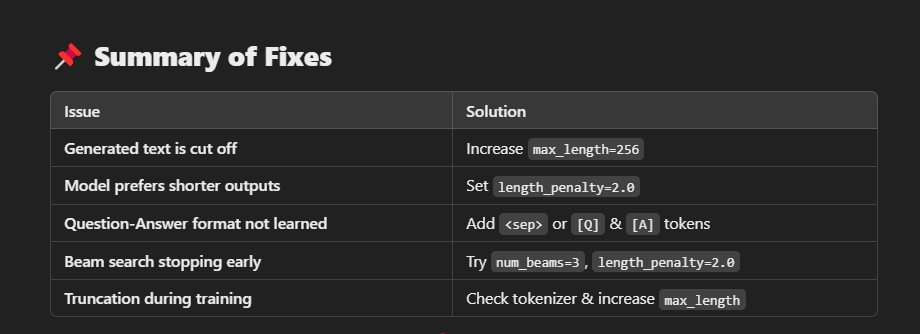

In [85]:
predictions = []
true_labels = []
contexts = []
device = "cuda"
for example in test_processed[20:40]:
    input_ids = example["input_ids"].unsqueeze(0).to(device)
    attention_mask = example["attention_mask"].unsqueeze(0).to(device)

    # Decode the input context
    context_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    contexts.append(context_text)

    # Extract the true label (ground truth)
    true_label_ids = example["labels"]
    true_label_text = tokenizer.decode(true_label_ids, skip_special_tokens=True)
    true_labels.append(true_label_text)

    # Generate prediction
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=512,
            do_sample = True,
            # num_beams=5,
            # length_penalty=2.0,  # Increase length preference
            top_p = 0.9,
            temperature = 0.7,
            num_return_sequences = 5,
            early_stopping=True
        )

    predicted_text = tokenizer.decode(output_ids[0], skip_special_tokens=True) # try False
    predictions.append(predicted_text)

# Print some sample results
for i, (context, pred, true) in enumerate(zip(contexts[:], predictions[:], true_labels[:])):
    print(f"Example {i+1}:")
    print(f"  Context (Input): {context}")
    print(f"  Prediction: {pred}")
    print(f"  Ground Truth: {true}")
    print("------------")

# Compute BLEU score
bleu_scores = [sentence_bleu([true.split()], pred.split()) for true, pred in zip(true_labels, predictions)]
average_bleu = sum(bleu_scores) / len(bleu_scores)

print(f"BLEU Score: {average_bleu:.4f}")

Example 1:
  Context (Input): ูุงุช ุงููุณุชุดุงุฑ ุงูุฃููุงูู ุฃุฏููู ูุชูุฑ ูู 30 ุฃุจุฑูู 1945 ููุชุญุฑุง ุนู ุทุฑูู ุชูุงูู ูุงุฏุฉ ุงูุณูุงููุฏ ุงูุณุงูุฉ ูุฅุทูุงู ุงููุงุฑ ุนูู ููุณู ููู ุงูุฑูุงูุฉ ุงูุนุงูุฉ ุงูููุจููุฉ ูุทุฑููุฉ ููุช ุงูุฒุนูู ุงููุงุฒู ูููู ูุฐู ุงูุทุฑููุฉ ุงููุฒุฏูุฌุฉ ูู ุงูุงูุชุญุงุฑ ูุงูุธุฑูู ุงูุฃุฎุฑู ุงูุชู ุฃุญุงุทุช ุจุงูุญุงุฏุซุฉ ุดุฌุนุช ุงูุจุนุถ ุนูู ุฅุทูุงู ุงูุดุงุฆุนุงุช ุจุฃู ูุชูุฑ ูู ููุชุญุฑ ูุฃูู ุนุงุด ุญุชู ููุงูุฉ ุงูุญุฑุจ ุงูุนุงูููุฉ ุงูุซุงููุฉ ูุน ุงูุงุฎุชูุงู ุญูู ูุง ุญุฏุซ ูุฌุซุชู ููุฏ ุฃูุฏุช ุงููุซุงุฆู ุงูุณูููุชูุฉ ุงูููุฑุฌ ุนููุง ูู ุฌูุงุฒู ูู ุฌู ุจู ูุฌูุงุฒ ุงูุฃูู ุงูููุฏุฑุงูู ุงูุฑูุณู ุณูุฉ 1993 ุงูุฑูุงูุฉ ุงูุชู ุชููู ุจุงูุชุญุงุฑู ูููููุง ูู ุชุธูุฑ ูุง ุญุฏุซ ูุจูุงูุง ุฌุซุชู ุจุนุฏ ุญุฑููุง
  Prediction: ูุชู 